# Predictive Analysis of Robinhood Popularity Data - Pre-Processing

Purpose: In this module, we pick up from Part Two - where we explored the data and added features to the dataset.

Our goal in Part Three of Pre-Processing, we will prepare the data for our machine learning models.

This may involve creating dummy features if appropriate, scaling the dataset, and splitting the data between the test and traing data.

We also want to use some techniques from our EDA work again to check if there any issues (collinerity) in the features.

In [10]:
# Importing modules for data pre-processing

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [11]:
# Let's read in our new dataset from Part Two

filepath = '../data/stock_data_new.csv'
df = pd.read_csv(filepath)
print(df.head())

# Let's also get a list of the stock basket tickers
filepath = '../data/stock_info.csv'
stock = pd.read_csv(filepath)
tickers = stock['Ticker'].tolist()
print(tickers)

   Unnamed: 0        Date  Robinhood      Price    Volume Ticker Company  \
0           0  2018-07-02   150897.0  46.794998  70925200   AAPL   Apple   
1           1  2018-07-03   151073.0  45.980000  55819200   AAPL   Apple   
2           2  2018-07-05   151258.0  46.349998  66416800   AAPL   Apple   
3           3  2018-07-06   151150.0  46.992500  69940800   AAPL   Apple   
4           4  2018-07-09   150664.0  47.645000  79026400   AAPL   Apple   

   Percentage_Volume  ExPost_PriceChange_1D  ExPost_PriceChange_5D  ...  \
0           0.002128                    NaN                    NaN  ...   
1           0.002706              -0.017416                    NaN  ...   
2           0.002277               0.008047                    NaN  ...   
3           0.002161               0.013862                    NaN  ...   
4           0.001907               0.013885                    NaN  ...   

   ExPost_PriceChange_1D_Lag2  ExPost_PriceChange_1D_Lag3  \
0                         NaN  

In [12]:
#Checking for null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10060 entries, 0 to 10059
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  10060 non-null  int64  
 1   Date                        10060 non-null  object 
 2   Robinhood                   10060 non-null  float64
 3   Price                       10060 non-null  float64
 4   Volume                      10060 non-null  int64  
 5   Ticker                      10060 non-null  object 
 6   Company                     10060 non-null  object 
 7   Percentage_Volume           10060 non-null  float64
 8   ExPost_PriceChange_1D       10040 non-null  float64
 9   ExPost_PriceChange_5D       9960 non-null   float64
 10  ExPost_PriceChange_10D      9860 non-null   float64
 11  ExAnte_PriceChange_1D       10040 non-null  float64
 12  ExAnte_PriceChange_3D       10000 non-null  float64
 13  ExAnte_PriceChange_5D       996

The null values are explainable by the feature engineering we used in Part Two.

(1) ExPost_PriceChange_1D, ExPost_PriceChange_5D, ExPost_PriceChange_10D will have null values at the beginning of the time series because of the data required to make this calculation.

(2) ExAnte_PriceChange_1D, ExAnte_PriceChange_3D, ExAnte_PriceChange_5D will have null values at the end of the time series because of the data required to make this calculation.

(3) Lag Features (Robinhood_LagX, Percentage_Volume_LagY, ExPost_PriceChange_1D_LagZ) have starting null values because of the lagging nature.

(4) Simple moving averages (SMA_3D, SMA_5D, SMA_10D) and Expanded_Mean will have null values at the beginning of the time series because of the data required to make this calculation.

Since these represent just a few datapoints, we are comfortable dropping those null values.

In [13]:
df.dropna(axis=0, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9760 entries, 10 to 10054
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  9760 non-null   int64  
 1   Date                        9760 non-null   object 
 2   Robinhood                   9760 non-null   float64
 3   Price                       9760 non-null   float64
 4   Volume                      9760 non-null   int64  
 5   Ticker                      9760 non-null   object 
 6   Company                     9760 non-null   object 
 7   Percentage_Volume           9760 non-null   float64
 8   ExPost_PriceChange_1D       9760 non-null   float64
 9   ExPost_PriceChange_5D       9760 non-null   float64
 10  ExPost_PriceChange_10D      9760 non-null   float64
 11  ExAnte_PriceChange_1D       9760 non-null   float64
 12  ExAnte_PriceChange_3D       9760 non-null   float64
 13  ExAnte_PriceChange_5D       976

Here is a summary of the dataset we're working with.

Number of observations: 9,760

Number of Features: 32

Feature Names: Robinhood, Ticker, Percentage_Volume, Year, Month, Day, Day_of_Week, Robinhood_LagX (1...7), Percentage_Volume_LagY (1...7), ExPost_PriceChange_1D_LagZ (1...7), SMA_3D, SMA_5D, SMA_10D, Expanded_Mean

Number of Target Variables: 6

Name of Target Variables: ExPost_PriceChange_1D, ExPost_PriceChange_5D, ExPost_PriceChange_10D, ExAnte_PriceChange_1D, ExAnte_PriceChange_1D, ExAnte_PriceChange_3D, ExAnte_PriceChange_5D

Let's rearrange our dataframe with the features on the left and target variables on the right, and dropping any extraneous variables.

In [14]:
feature_names = ['Ticker', 'Year', 'Month', 'Day', 'Day_of_Week', 'Robinhood', 'Percentage_Volume', 'Robinhood_Lag1', 'Robinhood_Lag2', 'Robinhood_Lag3', 'Robinhood_Lag4', 'Robinhood_Lag5', 'Robinhood_Lag6', 'Robinhood_Lag7', 'Percentage_Volume_Lag1', 'Percentage_Volume_Lag2', 'Percentage_Volume_Lag3', 'Percentage_Volume_Lag4', 'Percentage_Volume_Lag5', 'Percentage_Volume_Lag6', 'Percentage_Volume_Lag7', 'ExPost_PriceChange_1D_Lag1', 'ExPost_PriceChange_1D_Lag2', 'ExPost_PriceChange_1D_Lag3', 'ExPost_PriceChange_1D_Lag4', 'ExPost_PriceChange_1D_Lag5', 'ExPost_PriceChange_1D_Lag6', 'ExPost_PriceChange_1D_Lag7', 'SMA_3D', 'SMA_5D', 'SMA_10D', 'Expanded_Mean']
target_names = ['ExPost_PriceChange_1D', 'ExPost_PriceChange_5D', 'ExPost_PriceChange_10D', 'ExAnte_PriceChange_1D', 'ExAnte_PriceChange_3D', 'ExAnte_PriceChange_5D']

df_new = df[feature_names + target_names].reset_index(drop=True)
df_new.head()

,Ticker,Year,Month,Day,Day_of_Week,Robinhood,Percentage_Volume,Robinhood_Lag1,Robinhood_Lag2,Robinhood_Lag3,...,SMA_3D,SMA_5D,SMA_10D,Expanded_Mean,ExPost_PriceChange_1D,ExPost_PriceChange_5D,ExPost_PriceChange_10D,ExAnte_PriceChange_1D,ExAnte_PriceChange_3D,ExAnte_PriceChange_5D
0,AAPL,2018,7,17,1,150065.0,0.002415,150087.0,150117.0,150592.0,...,0.000735,0.001199,0.002316,0.002316,0.002829,0.005779,0.022812,-0.005484,-0.000052,0.008096
1,AAPL,2018,7,18,2,150523.0,0.002295,150065.0,150087.0,150117.0,...,-0.001617,0.002697,0.003510,0.001607,-0.005484,0.013413,0.035233,0.007773,0.006355,0.023214
2,AAPL,2018,7,19,3,150750.0,0.001858,150523.0,150065.0,150087.0,...,0.001706,0.000899,0.003482,0.002121,0.007773,0.004450,0.034952,-0.002293,0.005837,0.012143
3,AAPL,2018,7,20,4,150839.0,0.001824,150750.0,150523.0,150065.0,...,-0.000001,0.000126,0.001867,0.001782,-0.002293,0.000575,0.018460,0.000888,0.017656,-0.002403
4,AAPL,2018,7,23,0,151029.0,0.002361,150839.0,150750.0,150523.0,...,0.002123,0.000742,0.000567,0.001718,0.000888,0.003667,0.005405,0.007254,0.013569,-0.008872


Let's also convert out stock tickers categorical data to dummy variables.

Although this is not necessary for some machine learning models like decision trees, we want to have the same dataset in case we want to standarize this pre-processing in the future.

In [15]:
df_new = pd.get_dummies(df_new)

df_new.head()

,Year,Month,Day,Day_of_Week,Robinhood,Percentage_Volume,Robinhood_Lag1,Robinhood_Lag2,Robinhood_Lag3,Robinhood_Lag4,...,Ticker_NKE,Ticker_NVDA,Ticker_PYPL,Ticker_SNAP,Ticker_SQ,Ticker_T,Ticker_TSLA,Ticker_TWTR,Ticker_V,Ticker_ZNGA
0,2018,7,17,1,150065.0,0.002415,150087.0,150117.0,150592.0,150575.0,...,0,0,0,0,0,0,0,0,0,0
1,2018,7,18,2,150523.0,0.002295,150065.0,150087.0,150117.0,150592.0,...,0,0,0,0,0,0,0,0,0,0
2,2018,7,19,3,150750.0,0.001858,150523.0,150065.0,150087.0,150117.0,...,0,0,0,0,0,0,0,0,0,0
3,2018,7,20,4,150839.0,0.001824,150750.0,150523.0,150065.0,150087.0,...,0,0,0,0,0,0,0,0,0,0
4,2018,7,23,0,151029.0,0.002361,150839.0,150750.0,150523.0,150065.0,...,0,0,0,0,0,0,0,0,0,0


Let's check the shape of our training and target data sets.

In [7]:
X = df_new.drop(target_names, axis=1)
y = df_new[target_names]

print(X.shape)
print(y.shape)

(9760, 51)
(9760, 6)


Now we're ready to apply the Standard Scaler to our training data.

However, we don't need to apply it to our dummy variables so let's use a Column Transformer which allows us to selectively applying to certain columns.

In [8]:
scaled_columns = ['Year', 'Month', 'Day', 'Day_of_Week', 'Robinhood', 'Percentage_Volume', 
                  'Robinhood_Lag1', 'Robinhood_Lag2', ]


scaler = StandardScaler()


X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)


X.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,9760.0,1.368669e-13,1.000051,-1.449871,-0.011788,-0.011788,-0.011788,1.426296
Month,9760.0,8.450606e-16,1.000051,-1.587860,-1.012173,-0.004719,1.002735,1.578423
Day,9760.0,-7.261951e-17,1.000051,-1.700274,-0.898710,0.017364,0.818929,1.735003
Day_of_Week,9760.0,-1.565232e-16,1.000051,-1.436232,-0.725399,-0.014566,0.696266,1.407099
Robinhood,9760.0,8.577155e-16,1.000051,-1.354866,-0.854969,-0.115674,0.502786,5.485896
Percentage_Volume,9760.0,3.840792e-16,1.000051,-0.937867,-0.634820,-0.276622,0.230646,14.620607
Robinhood_Lag1,9760.0,1.712656e-16,1.000051,-1.357112,-0.856723,-0.113095,0.506158,5.442796
Robinhood_Lag2,9760.0,-1.286539e-16,1.000051,-1.359191,-0.857762,-0.110459,0.510609,5.434289
Robinhood_Lag3,9760.0,-4.937762e-16,1.000051,-1.361193,-0.858068,-0.108185,0.514730,5.425214
Robinhood_Lag4,9760.0,6.409718e-16,1.000051,-1.363159,-0.858492,-0.105942,0.518160,5.422968


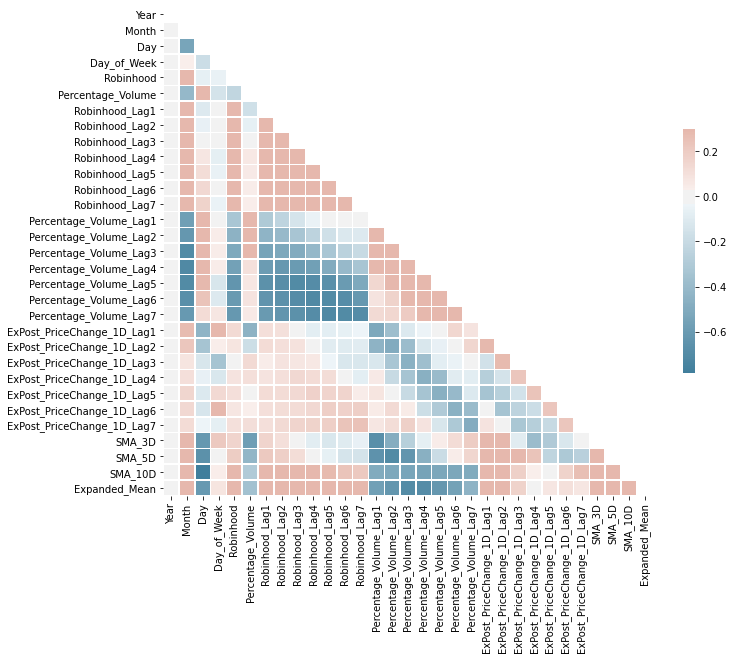

In [9]:
# Compute the correlation matrix
corr = X.iloc[:31,:31].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})